In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Классификация позиции игрока по данным FIFA 19

## Описание датасета: FIFA 19 — Классификация позиции игрока

### Целевая переменная:
- `PositionCategory` — обобщённая игровая позиция:
  - `GK` — вратарь
  - `DEF` — защитник
  - `MID` — полузащитник
  - `ATT` — нападающий

---

###  Основные характеристики:
- **Количество записей**: ~16,000 игроков
- **Количество признаков**: ~20–30 (в зависимости от отбора), все числовые
- **Тип задачи**: Многоклассовая классификация (4 класса)

---

###  Используемые признаки:
- `Age` — возраст игрока  
- `Overall` — общий рейтинг  
- `Potential` — потенциальный максимум рейтинга  
- `Value`, `Wage` — рыночная стоимость и зарплата  
- `International Reputation` — известность на международной арене  
- `Weak Foot` — владение слабой ногой  
- `Skill Moves` — техника  
- `Work Rate` — рабочая нагрузка (атакующая/защитная)  
- `Pace`, `Shooting`, `Passing`, `Dribbling`, `Defending`, `Physical` — игровые навыки  
- `Height`, `Weight`, `Body Type` — физические параметры  




# 1 Загрузка и первичный анализ

Импортируем библиотеки

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

Загружаем данные с помощью команды ```pd.read_csv()```



In [3]:
pd.set_option('display.max_columns', None)

In [4]:
df=pd.read_csv('/content/drive/MyDrive/Fifa19.csv')

In [5]:
print("Форма таблицы:", df.shape)

df.head()

Форма таблицы: (16344, 89)


,Club,Playing_in_League,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club Logo,Value,Wage,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Work Rate,Body Type,Real Face,Position,Jersey Number,Joined,Loaned From,Contract Valid Until,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,Real Madrid,Spain Primera Division (1),177003,L. Modrić,32,https://cdn.sofifa.org/players/4/19/177003.png,Croatia,https://cdn.sofifa.org/flags/10.png,91,91,https://cdn.sofifa.org/teams/2/light/243.png,€67M,€420K,2280,Right,4.0,4.0,4.0,High/ High,Lean,Yes,RCM,10.0,"Aug 1, 2012",NaN,2020,5'8,146lbs,77+3,77+3,77+3,85+3,84+3,84+3,84+3,85+3,87+3,87+3,87+3,86+3,88+3,88+3,88+3,86+3,82+3,81+3,81+3,81+3,82+3,79+3,71+3,71+3,71+3,79+3,86.0,72.0,55.0,93.0,76.0,90.0,85.0,78.0,88.0,93.0,80.0,72.0,93.0,90.0,94.0,79.0,68.0,89.0,58.0,82.0,62.0,83.0,79.0,92.0,82.0,84.0,60.0,76.0,73.0,13.0,9.0,7.0,14.0,9.0,€137.4M
1,Real Madrid,Spain Primera Division (1),155862,Sergio Ramos,32,https://cdn.sofifa.org/players/4/19/155862.png,Spain,https://cdn.sofifa.org/flags/45.png,91,91,https://cdn.sofifa.org/teams/2/light/243.png,€51M,€380K,2201,Right,4.0,3.0,3.0,High/ Medium,Normal,Yes,RCB,15.0,"Aug 1, 2005",NaN,2020,6'0,181lbs,73+3,73+3,73+3,70+3,71+3,71+3,71+3,70+3,71+3,71+3,71+3,72+3,75+3,75+3,75+3,72+3,81+3,84+3,84+3,84+3,81+3,84+3,87+3,87+3,87+3,84+3,66.0,60.0,91.0,78.0,66.0,63.0,74.0,72.0,77.0,84.0,76.0,75.0,78.0,85.0,66.0,79.0,93.0,84.0,83.0,59.0,88.0,90.0,60.0,63.0,75.0,82.0,87.0,92.0,91.0,11.0,8.0,9.0,7.0,11.0,€104.6M
2,Real Madrid,Spain Primera Division (1),182521,T. Kroos,28,https://cdn.sofifa.org/players/4/19/182521.png,Germany,https://cdn.sofifa.org/flags/21.png,90,90,https://cdn.sofifa.org/teams/2/light/243.png,€76.5M,€355K,2190,Right,4.0,5.0,3.0,Medium/ Medium,Normal,Yes,LCM,8.0,"Jul 17, 2014",NaN,2022,6'0,168lbs,78+3,78+3,78+3,81+3,82+3,82+3,82+3,81+3,84+3,84+3,84+3,82+3,86+3,86+3,86+3,82+3,79+3,82+3,82+3,82+3,79+3,77+3,72+3,72+3,72+3,77+3,88.0,76.0,54.0,92.0,82.0,81.0,86.0,84.0,93.0,90.0,64.0,62.0,70.0,89.0,71.0,87.0,30.0,75.0,73.0,92.0,60.0,82.0,79.0,86.0,73.0,85.0,72.0,79.0,69.0,10.0,11.0,13.0,7.0,10.0,€156.8M
3,Real Madrid,Spain Primera Division (1),192119,T. Courtois,26,https://cdn.sofifa.org/players/4/19/192119.png,Belgium,https://cdn.sofifa.org/flags/7.png,89,90,https://cdn.sofifa.org/teams/2/light/243.png,€53.5M,€240K,1311,Left,4.0,2.0,1.0,Medium/ Medium,Courtois,Yes,GK,1.0,"Aug 9, 2018",NaN,2024,6'6,212lbs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.0,14.0,13.0,33.0,12.0,13.0,19.0,20.0,35.0,23.0,46.0,52.0,61.0,84.0,45.0,36.0,68.0,38.0,70.0,17.0,23.0,15.0,13.0,44.0,27.0,66.0,20.0,18.0,16.0,85.0,91.0,72.0,86.0,88.0,€113.7M
4,Real Madrid,Spain Primera Division (1),200145,Casemiro,26,https://cdn.sofifa.org/players/4/19/200145.png,Brazil,https://cdn.sofifa.org/flags/54.png,88,90,https://cdn.sofifa.org/teams/2/light/243.png,€59.5M,€285K,2170,Right,3.0,3.0,2.0,Medium/ High,Normal,Yes,CDM,14.0,"Jul 11, 2013",NaN,2021,6'1,185lbs,72+3,72+3,72+3,69+3,73+3,73+3,73+3,69+3,74+3,74+3,74+3,71+3,80+3,80+3,80+3,71+3,78+3,85+3,85+3,85+3,78+3,79+3,85+3,85+3,85+3,79+3,52.0,59.0,76.0,85.0,53.0,69.0,59.0,74.0,82.0,78.0,59.0,65.0,62.0,84.0,66.0,86.0,88.0,87.0,89.0,79.0,87.0,87.0,69.0,77.0,66.0,84.0,88.0,90.0,87.0,13.0,14.0,16.0,12.0,12.0,€126.4M


Проведем первичный анализ

In [6]:
print("Первые 5 строк данных:")
print(df.head())
print("\nИнформация о данных:")
print(df.info())
print("\nОписательные статистики:")
print(df.describe())

Первые 5 строк данных:
          Club           Playing_in_League      ID          Name  Age  \
0  Real Madrid  Spain Primera Division (1)  177003     L. Modrić   32   
1  Real Madrid  Spain Primera Division (1)  155862  Sergio Ramos   32   
2  Real Madrid  Spain Primera Division (1)  182521      T. Kroos   28   
3  Real Madrid  Spain Primera Division (1)  192119   T. Courtois   26   
4  Real Madrid  Spain Primera Division (1)  200145      Casemiro   26   

                                            Photo Nationality  \
0  https://cdn.sofifa.org/players/4/19/177003.png     Croatia   
1  https://cdn.sofifa.org/players/4/19/155862.png       Spain   
2  https://cdn.sofifa.org/players/4/19/182521.png     Germany   
3  https://cdn.sofifa.org/players/4/19/192119.png     Belgium   
4  https://cdn.sofifa.org/players/4/19/200145.png      Brazil   

                                  Flag  Overall  Potential  \
0  https://cdn.sofifa.org/flags/10.png       91         91   
1  https://cdn.sofifa.o

In [7]:
missing=df.isnull().sum()
missing[missing>0].sort_values(ascending=False)

,0
Loaned From,15210
RAM,1859
CAM,1859
CF,1859
RF,1859
...,...
SlidingTackle,40
GKHandling,40
GKKicking,40
GKPositioning,40


# 2. Очистка данных и создание целевой переменной

In [8]:
print(df.columns)

Index(['Club', 'Playing_in_League', 'ID', 'Name', 'Age', 'Photo',
       'Nationality', 'Flag', 'Overall', 'Potential', 'Club Logo', 'Value',
       'Wage', 'Special', 'Preferred Foot', 'International Reputation',
       'Weak Foot', 'Skill Moves', 'Work Rate', 'Body Type', 'Real Face',
       'Position', 'Jersey Number', 'Joined', 'Loaned From',
       'Contract Valid Until', 'Height', 'Weight', 'LS', 'ST', 'RS', 'LW',
       'LF', 'CF', 'RF', 'RW', 'LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM',
       'RM', 'LWB', 'LDM', 'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB',
       'Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys',
       'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl',
       'Acceleration', 'SprintSpeed', 'Agility', 'Reactions', 'Balance',
       'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots',
       'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties',
       'Composure', 'Marking', 'StandingTackle', 'S

Очистка и фильтрация признаков

In [9]:
columns_to_drop = ['Photo', 'Flag', 'Club Logo', 'Work Rate', 'Body Type', 'Real Face',
                   'Joined', 'Loaned From', 'Contract Valid Until', 'Release Clause',
                   'Jersey Number', 'ID', 'Name', 'Club', 'Nationality', 'Weak Foot',
                   'Skill Moves', 'Special', 'Preferred Foot']
df.drop(columns=[col for col in columns_to_drop if col in df.columns], inplace=True)

Удаление строк с пустыми значениями в позиции

In [10]:
df = df[df['Position'].notnull()]

Создание целевой переменной, а также удаление игроков с редкими/нестандартными позициями.

In [11]:
def map_positions(pos):
  if pos=='GK':
    return 'GK'
  elif pos in ['CB','RB','LB','LWB','RWB']:
    return 'DEF'
  elif pos in ['CDM','CM','CAM','RM','LM']:
    return 'MID'
  elif pos in ['ST','CF','LW','RW']:
    return 'ATT'
  else:
    return 'Other'
df['PositionCategory']=df['Position'].apply(map_positions)
df=df[df['PositionCategory']!='Other']

Проверка распределения классов

In [12]:
df['PositionCategory'].value_counts()

,count
PositionCategory,
MID,4941
DEF,4116
ATT,2668
GK,1819


# 3. Разведочный анализ данных (EDA)

На этом этапе визуализирую распределения и зависимости в данных, чтобы понять, какие признаки могут быть полезными для классификации.
В частности,интересует, какие скиллы различают вратарей, защитников, полузащитников и нападающих.
Также посмотрю на корреляции и плотности распределений признаков по категориям.

Распределение целевой переменной

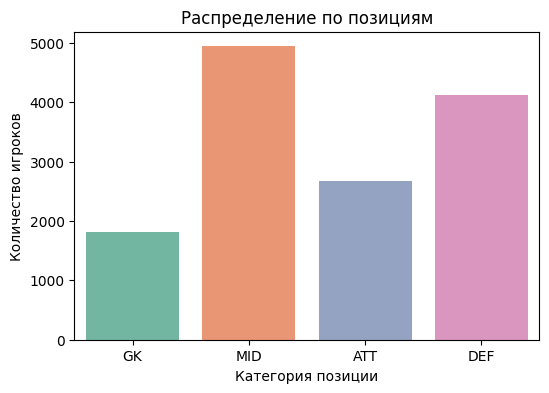

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.countplot(data=df, x='PositionCategory', palette='Set2')
plt.title('Распределение по позициям')
plt.xlabel('Категория позиции')
plt.ylabel('Количество игроков')
plt.show()

Boxplot по некоторым ключевым признакам

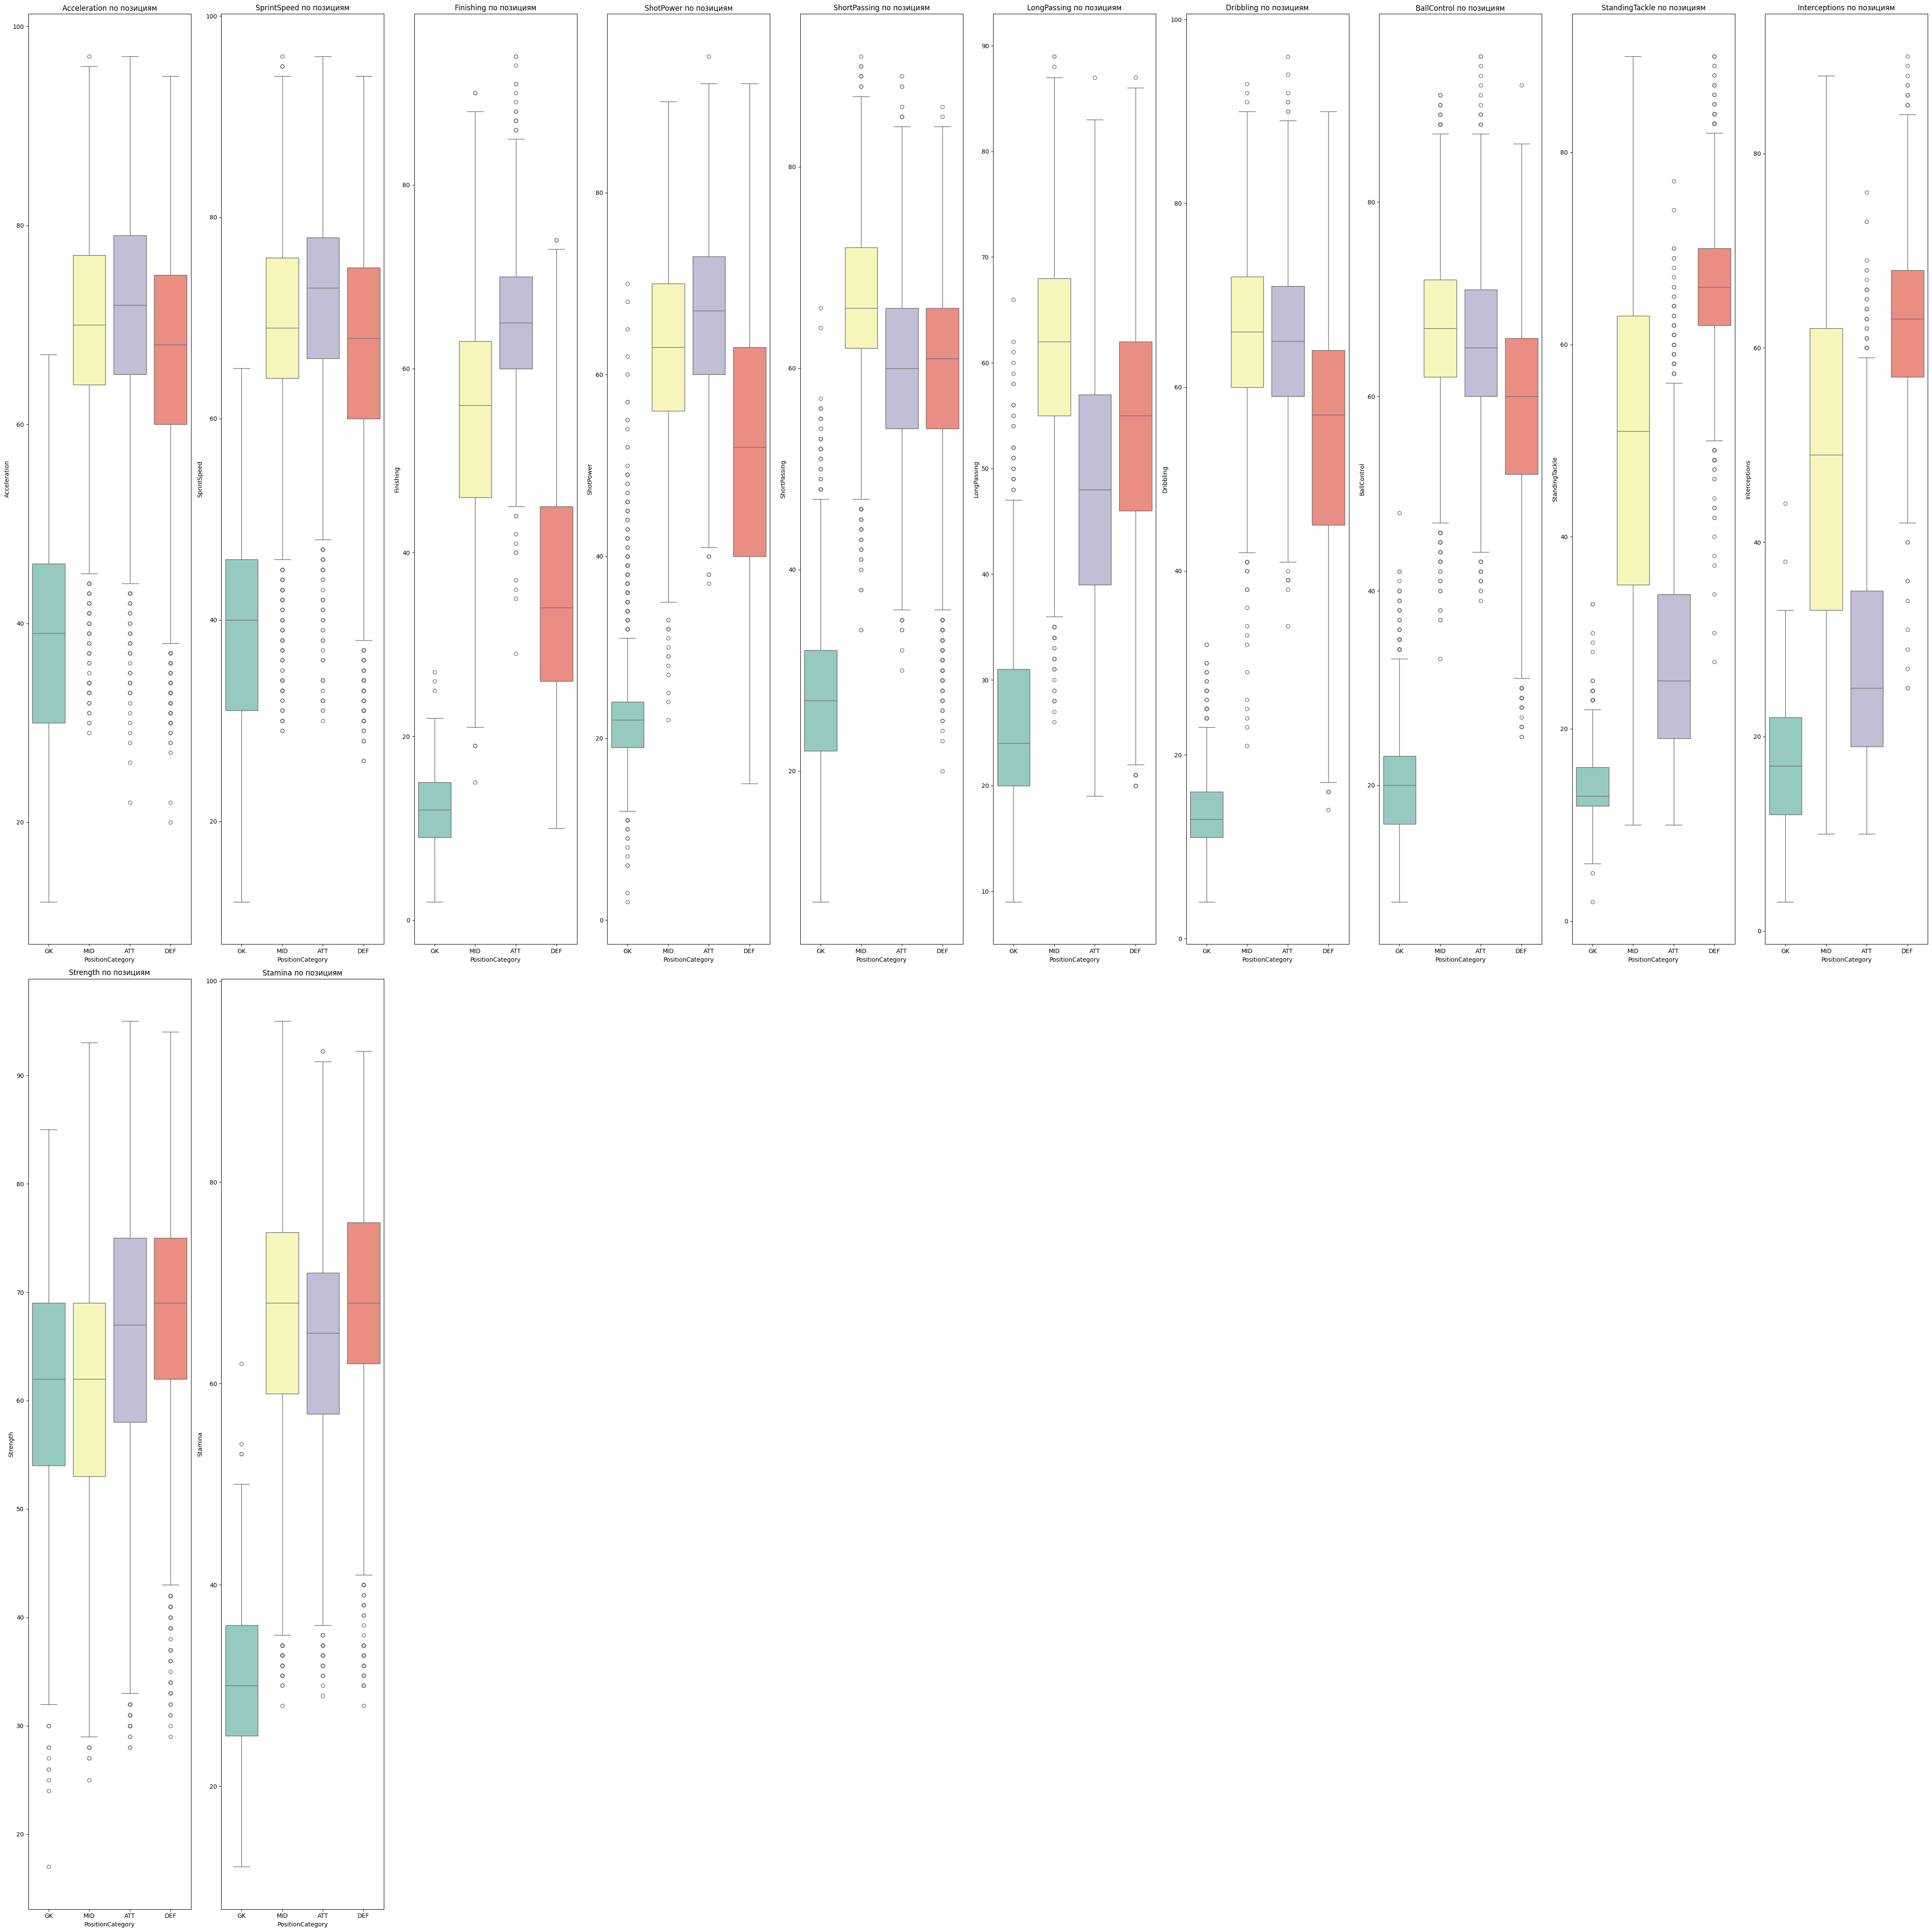

In [14]:
key_features = ['Acceleration', 'SprintSpeed',
                'Finishing', 'ShotPower',
                'ShortPassing', 'LongPassing',
                'Dribbling', 'BallControl',
                'StandingTackle', 'Interceptions',
                'Strength', 'Stamina']

plt.figure(figsize=(45,45))
for i, feature in enumerate(key_features):
    plt.subplot(2, 10, i+1)
    sns.boxplot(data=df, x='PositionCategory', y=feature, palette='Set3')
    plt.title(f'{feature} по позициям')
plt.tight_layout()
plt.show()

Корреляционная матрица

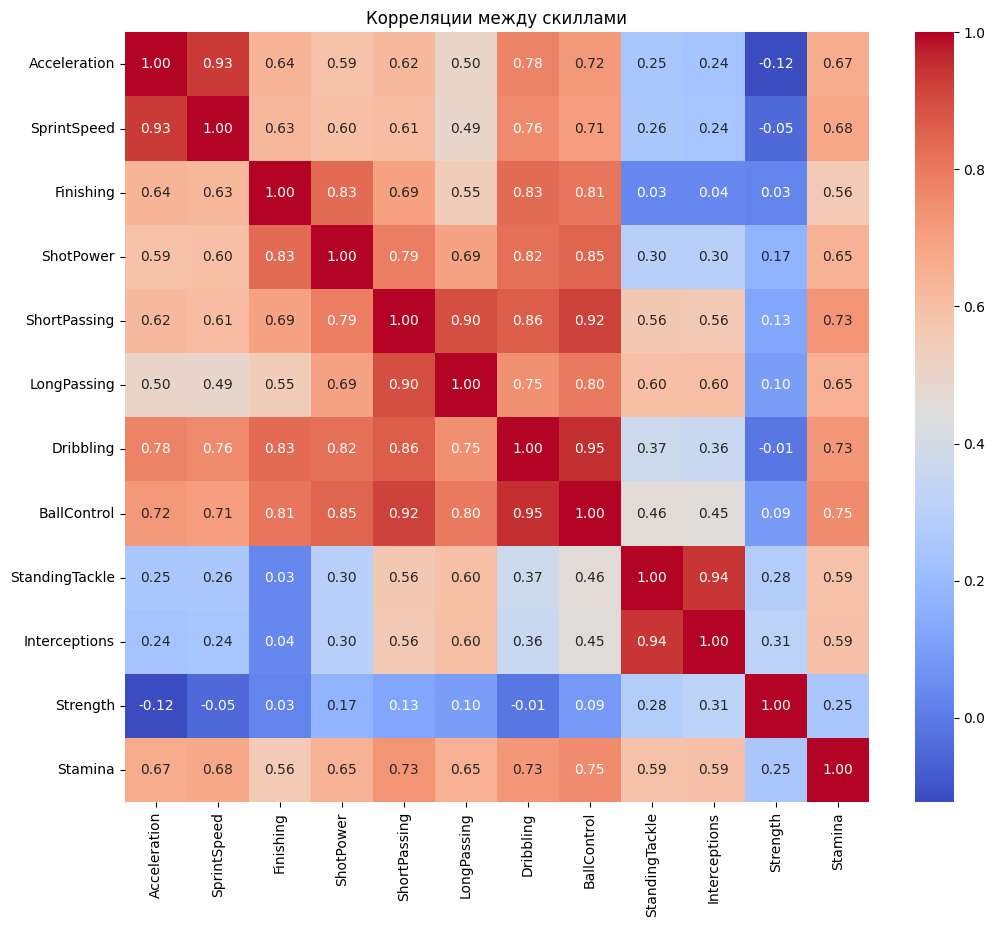

In [15]:
plt.figure(figsize=(12, 10))
sns.heatmap(df[key_features].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Корреляции между скиллами')
plt.show()

Визуализация t-SNE

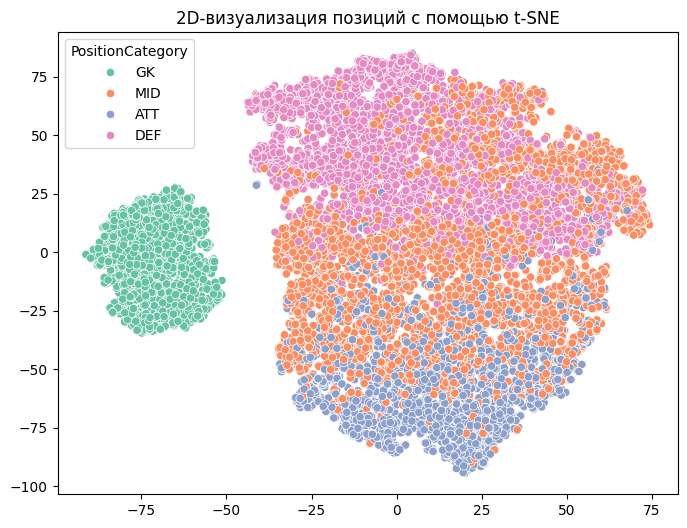

In [16]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

df_viz = df.dropna(subset=key_features)
X_viz = df_viz[key_features]
y_viz = df_viz['PositionCategory']

X_scaled = StandardScaler().fit_transform(X_viz)

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=y_viz, palette='Set2')
plt.title('2D-визуализация позиций с помощью t-SNE')
plt.show()

- Распределение классов в целевой переменной `PositionCategory` достаточно сбалансировано, что делает задачу классификации устойчивой.
- Различия между позициями хорошо визуализируются с помощью boxplot'ов по отдельным признакам:
  - Вратари (`GK`) существенно отличаются от всех других по признакам вроде `Strength`, `Agility`, `Reactions`.
  - Защитники (`DEF`) имеют высокие значения в `StandingTackle`, `Interceptions`, `Aggression`.
  - Полузащитники (`MID`) выделяются в `ShortPassing`, `Vision`, `BallControl`.
  - Нападающие (`ATT`) сильны в `Finishing`, `ShotPower`, `Dribbling`, `Acceleration`.
- Между признаками наблюдаются логичные корреляции, например:
  - `SprintSpeed` и `Acceleration` — сильно связаны.
  - `ShotPower` и `Finishing` — тоже положительно коррелируют.
- На t-SNE визуализации видно, что позиции формируют кластеры, хотя с пересечениями — это означает, что задача классификации имеет смысл.

# 4. Преобразования и Feature Engineering

На этом этапе мы:
- выберем признаки, которые будем использовать для классификации;
- преобразуем категориальные признаки (если они есть);
- масштабируем числовые признаки (при необходимости);
- разобьём данные на обучающую и тестовую выборки.

**Выбор признаков**

In [17]:
selected_features = [
    'Acceleration', 'SprintSpeed',
    'Finishing', 'ShotPower',
    'ShortPassing', 'LongPassing',
    'Dribbling', 'BallControl',
    'StandingTackle', 'Interceptions',
    'Strength', 'Stamina'
]

X = df[selected_features]
y = df['PositionCategory']

**Удаляем строки с пропущенными значениями**

In [18]:
df_model = df[selected_features + ['PositionCategory']].dropna()
X = df_model[selected_features]
y = df_model['PositionCategory']

**Разделим на train/test**

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

**Масштабируем данные, чтобы признаки имели одинаковый вклад**

In [20]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 5. Обучение и сравнение моделей классификации

На этом этапе будут обучены 4 модели классификации:
- Логистическая регрессия
- Случайный лес
- Метод опорных векторов (SVM)
- K-ближайших соседей (KNN)

Для каждой модели:
- подберём гиперпараметры с помощью GridSearchCV,
- оценим точность на тестовой выборке,
- построим confusion matrix,
- сравним результаты.

Импортируем необходимы библиотеки

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

Функция для обучения и оценки модели

In [22]:
def train_and_evaluate(model, params, X_train, y_train, X_test, y_test):
    grid = GridSearchCV(model, params, cv=5, n_jobs=-1)
    grid.fit(X_train, y_train)

    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)

    print(f"Best parameters: {grid.best_params_}")
    print("Classification Report:\n", classification_report(y_test, y_pred))

    ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test, cmap="Blues")

    return best_model

Логистическая регрессия

Best parameters: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
Classification Report:
               precision    recall  f1-score   support

         ATT       0.81      0.76      0.78       534
         DEF       0.86      0.92      0.89       823
          GK       1.00      1.00      1.00       364
         MID       0.80      0.78      0.79       988

    accuracy                           0.85      2709
   macro avg       0.87      0.86      0.87      2709
weighted avg       0.85      0.85      0.85      2709



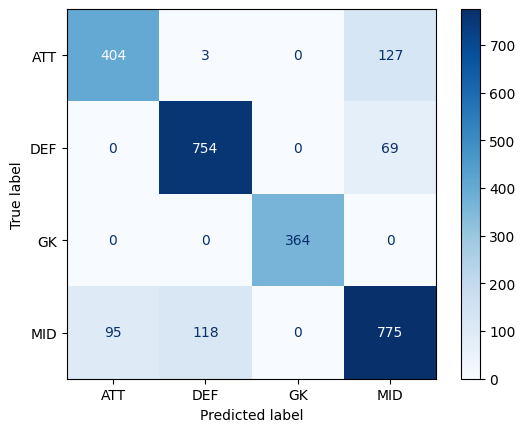

In [23]:
lr_params = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs']
}

lr_model = train_and_evaluate(LogisticRegression(max_iter=1000), lr_params, X_train_scaled, y_train, X_test_scaled, y_test)


Случайный лес

Best parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Classification Report:
               precision    recall  f1-score   support

         ATT       0.81      0.75      0.78       534
         DEF       0.86      0.92      0.89       823
          GK       1.00      1.00      1.00       364
         MID       0.80      0.79      0.79       988

    accuracy                           0.85      2709
   macro avg       0.87      0.86      0.86      2709
weighted avg       0.85      0.85      0.85      2709



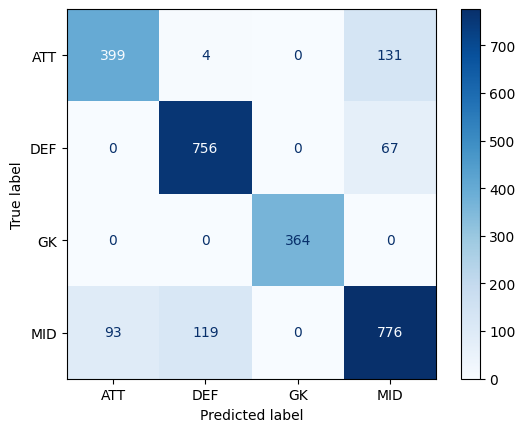

In [24]:
rf_params = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

rf_model = train_and_evaluate(RandomForestClassifier(random_state=42), rf_params, X_train, y_train, X_test, y_test)


Метод опорных векторов (SVM)

Best parameters: {'C': 10, 'kernel': 'rbf'}
Classification Report:
               precision    recall  f1-score   support

         ATT       0.83      0.74      0.78       534
         DEF       0.89      0.92      0.91       823
          GK       1.00      1.00      1.00       364
         MID       0.80      0.83      0.82       988

    accuracy                           0.86      2709
   macro avg       0.88      0.87      0.88      2709
weighted avg       0.86      0.86      0.86      2709



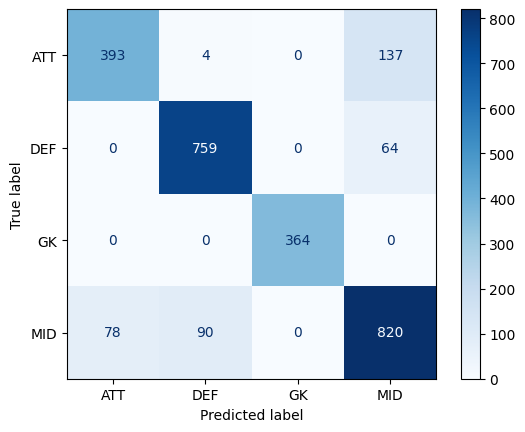

In [25]:
svm_params = {
    'C': [0.1, 1, 10],
    'kernel': ['rbf', 'linear']
}

svm_model = train_and_evaluate(SVC(), svm_params, X_train_scaled, y_train, X_test_scaled, y_test)

K-ближайших соседей (KNN)

Best parameters: {'n_neighbors': 9, 'weights': 'distance'}
Classification Report:
               precision    recall  f1-score   support

         ATT       0.80      0.72      0.76       534
         DEF       0.86      0.89      0.87       823
          GK       1.00      1.00      1.00       364
         MID       0.77      0.78      0.78       988

    accuracy                           0.83      2709
   macro avg       0.86      0.85      0.85      2709
weighted avg       0.83      0.83      0.83      2709



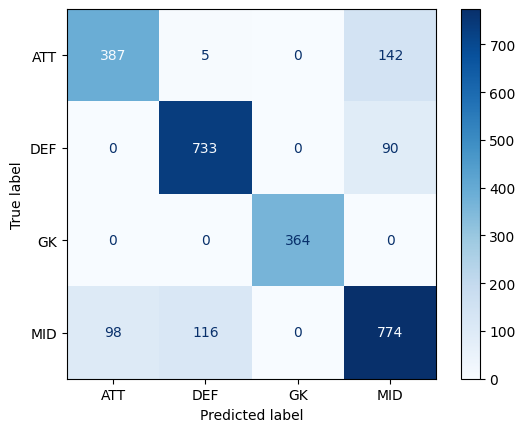

In [26]:
knn_params = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance']
}

knn_model = train_and_evaluate(KNeighborsClassifier(), knn_params, X_train_scaled, y_train, X_test_scaled, y_test)


##Сравнение моделей и анализ confusion matrices

На этом этапе мы обучили четыре классификатора для задачи определения позиции игрока (ATT, MID, DEF, GK):

- **Logistic Regression**
- **Random Forest**
- **Support Vector Machine (SVM)**
- **K-Nearest Neighbors (KNN)**

### Основные наблюдения:

1. **Все модели достигли высокой точности на тестовой выборке (~85%)**, что говорит о хорошей предсказательной способности.
2. **GK (Goalkeeper)** оказался самой легко классифицируемой категорией:
   - Во всех моделях метрики для GK — **precision, recall, F1 = 1.00**.
   - Это объясняется тем, что вратари значительно отличаются от остальных игроков по ряду характеристик (низкие значения в атакующих и технических навыках, специфический профиль).
3. По результатам confusion matrices видно, что:
   - **GK никогда не путается с другими позициями**.
   - Основные ошибки приходятся на классы **MID ↔ DEF** и **ATT ↔ MID**, что ожидаемо из-за схожих характеристик этих позиций.
4. **Random Forest и SVM показали лучшие результаты среди моделей**, особенно по классу MID, где часто наблюдаются ошибки у других классификаторов.

###  Выводы:

- Модель адекватно различает классы, особенно легко выделяя GK.
- Ошибки между полевыми позициями разумны и связаны с их пересечениями в игровых навыках.
- В дальнейшем возможно улучшение качества классификации за счёт feature engineering, отбора признаков и/или увеличения выборки.
